# A $5 \times 5$ grid

For this example, we will be working on this grid below :

<img src="https://github.com/Nicotous1/EmpathicTD/raw/master/docs/grid_5_5_def.png">

It is a five by five grid with one terminating state at the down-right corner. Every movement is costly of 0.5 unit while some red state will make you lose 5 units. There are no discounts ($\gamma = 1$) and only the terminating state make you earn 5 units and finish the game ($\gamma = 0$).

The behavior policy is a random walk modeling a drunk man with no prior. The target policy is a drunk man with a prior, he knows his home is at the bottom-right. Then, he is moving 50\% of time right and 50\% left. This is again an off-learning problem. Here you can see the off-learning TD like two men, one completely drunk, the other with a prior but forced to follow the drunk man. As he follows the second man, he wants to estimate at each step what would have been his reward without his friend. Both wants to escape the club weighted -5 units.

## Imports

In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Import the library folder to Python libraries.
import sys
sys.path.insert(0, "../library/") # Path of the library

# Library imports
from TD import EmphaticTD, OffTD # the algorithm to use
from models import Grid # An inherited class of Model to defined a grid
from policies import GridRandomWalkPolicy # A policy for grid model
from utils import comparatorTD # Tool to evaluate the TD algorithms on a model

In [2]:
# To make nice plot for Latex
%matplotlib notebook
plt.rcParams.update({'font.size': 13}) # for Latex
plt.rcParams['figure.figsize'] = [8, 5]

# Definition of the model

### First create your reward and discount matrices

The parameter of a grid model are not defined like for a usual model. Here, each parameter is defined for a state and not a transition. For example, the reward of a state is defined to 5, then every transition to this states will be earning 5. This is the same for the discounts.

You can define your parameter in the shape of your grid, it is helpful to visualize your grid parameter. However when put to the model class, the parameters will be flatten. You can quickly recover their shape by using reshape of numpy.

In [3]:
l = 5

In [4]:
# Define the reward for each state (shape of the grid)
R = np.zeros((l,l))
R[:] = -0.5
R[1:3, 1:3] = -5
R[4,4] = 5
R

array([[-0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -5. , -5. , -0.5, -0.5],
       [-0.5, -5. , -5. , -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5,  5. ]])

In [5]:
# Define the discounts for each state (shape of the grid)
D = np.ones((l,l))
D[:] = 1
D[4,4] = 0
D

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.]])

### Next initiate your policies

In [6]:
# Define the target and behaviro policies
pi = GridRandomWalkPolicy(p_down = 0.5, p_right = 0.5)
mu = GridRandomWalkPolicy(0.25,0.25, 0.25,0.25)

As usual, this policies are not initiate at the begining. For a state in the border, <b>if the transition is not possible, the player will stay on the same state</b>. For example with a random walk, in a corner you have 50% chance to stay at the corner because you cannot move in two directions.

### Build your model

In [7]:
# Define the model
model = Grid(
            ## Model definition
                l_x = l,
                l_y = l,
                features = np.identity(l*l), # identity features function
                R = R, # transition reward
                pi = pi, # target policy
                mu = mu, # behavior policy
    
            ## Parameters for TD
                I = np.ones((l*l)), # interest function
                discounts = D, # discount function
    
            ## Initialisation
                S0 = (0,0),
                theta0 = np.ones((l*l)),
             ) 

### Visiualize your parameters after loading the model

After the model is loaded, all parameters are now defined for each transition like for an usual model. Then to see your parameter you need to use the reshape argument of numpy.

In [8]:
model.R.shape # R is now defined for each transition

(25, 25)

In [9]:
pos = (2,2)
idx = model.coords_to_id(pos) # The id in the flatten matrix of the coords (2,2)
print("Reward from {} :".format(pos))
print(model.R[idx].reshape((l,l))) # The value of each state from (2,2)

Reward from (2, 2) :
[[-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -5.  -5.  -0.5 -0.5]
 [-0.5 -5.  -5.  -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5  5. ]]


In [10]:
pos = (4,0)
idx = model.coords_to_id(pos) # The id in the flatten matrix of the coords (2,2)
print("Transition probabilities from {} :".format(pos))
print(model.pi.P[idx].reshape((l,l))) # The transition probability of each state from (2,2)

Transition probabilities from (4, 0) :
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0. ]]


From the down-left corner, you stay or move right 50% of times.

# Running the comparator

In [11]:
# The algorithm you want to compare
off = OffTD(alpha = 0.01, lambdas=0)
emp = EmphaticTD(alpha = 0.001, lambdas=0)
algos = [off, emp]

# The tool to compare quickly
comparator = comparatorTD(algos, colors = ["red", "blue"], names = ["OffTD", "EmphaticTD"])

In [12]:
T, N = 25000, 100
comparator.run(model, T, N)

offTD has been computed for 25000 steps and 100 particles.
emphatic TD has been computed for 25000 steps and 100 particles.


# Plot the MSVE

To plot the MSVE, you need to have defined $v_\pi$. Here it is a bit long to calculate. So we use the limit of the emphatic algorithm to defined it. You can check that its limit is equal to $v_\pi$.

In [13]:
# Define v_pi from the limit of the emphatic algorithm
# WARNING : the limit is not always v_pi. In this case, you need to defined it manually !
# However, for this model, the limit is good. (it also works with the off-TD(0))
model.v_pi = emp.optimal(model)
model.v_pi.reshape(l,l).round(1)

array([[-6.9, -6.4, -2.1,  1.4,  1.5],
       [-6.4, -5.2, -0.2,  2.4,  2.5],
       [-2.1, -0.2,  2.8,  3.2,  3.5],
       [ 1.4,  2.4,  3.2,  4. ,  4.5],
       [ 1.5,  2.5,  3.5,  4.5,  5. ]])

<IPython.core.display.Javascript object>


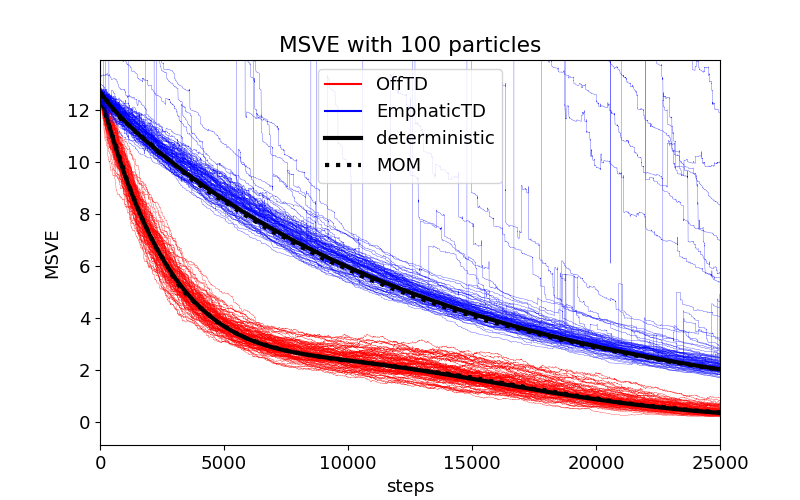

In [14]:
comparator.plot_msve()

# Conclusion

It is pretty easy to create a model of a grid and to compute the different algorithm on it. However it can quickly become expensive in memory as the model is bigger and require more time step to converge.

The small trick is to use the limit of one of the algorithm to defined $v_\pi$. Of course, you need to check that the value it gets is the true value. It is possible that the algorithm wont converge to the good $v_\pi$.